## 1. Cargamos librerías y el dataset

In [2]:
# Importamos las librerías necesarias
import pandas as pd
#import geopandas
#import shapely.wkt
#import rtree
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 100
%matplotlib inline
pd.set_option("display.max_rows", 101)

In [3]:
# Levantamos el dataset
propiedades_original = pd.read_csv("properatti.csv"
           , encoding = 'utf-8')

In [4]:
# Asignamos el dataset original a uno nuevo sobre el cual vamos a trabajar
propiedades = propiedades_original

In [5]:
# Como podemos ver la distribucion del precio no es normal por lo que usaremos la mediana para reemplazar los datos faltantes
# Cambiamos los valores Null Faltantes por la Mediana de acuerdo al tipo de vivienda (APARTAMENTO, PH , ETC)
###print(df[df["price_aprox_usd"].isnull()][null_columns]) --- vemos las filas que faltan en la media 
df2= propiedades.loc[(propiedades['property_type'] == "PH", )]
df2.loc[:,"price"].median()

125000.0

In [6]:
#### Reemplazamos por la mediana####
propiedades.loc[(propiedades['place_name'] == "PH", )]
propiedades['price_aprox_usd'] = propiedades['price_aprox_usd'].replace(np.nan, '160000')
#print(propiedades.loc[propiedades['price_aprox_usd'] == '160000'])

In [7]:
df2= propiedades.loc[(propiedades['property_type'] == "apartment", )]
df2.loc[:,"price_aprox_usd"].median()

138700.0

In [8]:
propiedades.loc[(propiedades['place_name'] == "apartment", )]
propiedades['price_aprox_usd'] = propiedades['price_aprox_usd'].replace(np.nan, '160000')

In [9]:
df2= propiedades.loc[(propiedades['property_type'] == "house", )]
df2.loc[:,"price_aprox_usd"].median()

185000.0

In [10]:
propiedades.loc[(propiedades['place_name'] == "house", )]
propiedades['price_aprox_usd'] = propiedades['price_aprox_usd'].replace(np.nan, '350000')


In [11]:
df2= propiedades.loc[(propiedades['property_type'] == "store", )]
df2.loc[:,"price_aprox_usd"].median()

160000.0

In [12]:
propiedades.loc[(propiedades['place_name'] == "store", )]
propiedades['price_aprox_usd'] = propiedades['price_aprox_usd'].replace(np.nan, '240000')


## 7. Preguntas al Dataset de Properatti

### 7.1 ¿En cuáles barrios de *Capital Federal* pueden encontrarse propiedades en venta, del tipo *Departamento* y por debajo del monto total de *60.000 dólares*?

In [13]:
#Seteo de parámetros de consulta:
state_name_filter = 'Capital Federal'
property_type_filter = 'apartment'
price_filter = 60000

In [14]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               121220 non-null object
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 non

In [15]:
#definimos la variable null columns
null_columns=propiedades.columns[propiedades.isnull().any()]
print(propiedades[null_columns].isnull().sum())

place_name                        23
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
description                        2
image_thumbnail                 3112
dtype: int64


In [16]:
# Vemos las filas a las que le faltan el precio
# Para mejorar la síntesis de nuestro análisis vamos a considerar solamente los barrios en Capital Federal
# También vamos a cambiar el #Nan# de los precios de la siguiente forma. Para que los valores faltantes 
# sean representativos en relacion a la muestra que tenemos; ante valores de distribución normal usaremos la media, 
# pero si la muestra tiene una distribución heterogénea usaremos la mediana
propiedades_en_zona = propiedades.drop(propiedades[propiedades.state_name!=state_name_filter].index)
propiedades_en_zona.shape

(32316, 26)

In [17]:
states = propiedades_en_zona['state_name'].unique()
print(states)
print('{} elementos distintos.'.format(states.size))

['Capital Federal']
1 elementos distintos.


In [18]:
barrios = propiedades_en_zona['place_name'].unique()
print(barrios)
print('{} elementos distintos.'.format(barrios.size))

['Mataderos' 'Liniers' 'Belgrano' 'Palermo Soho' 'Palermo' 'Flores'
 'Boedo' 'Las Cañitas' 'Puerto Madero' 'Balvanera' 'Caballito' 'Nuñez'
 'San Telmo' 'Almagro' 'Capital Federal' 'Colegiales' 'Floresta'
 'Barrio Norte' 'Barracas' 'Recoleta' 'Congreso' 'Villa Crespo'
 'Chacarita' 'Constitución' 'Villa Urquiza' 'Palermo Hollywood' 'Saavedra'
 'Monserrat' 'Pompeya' 'Parque Chas' 'Paternal' 'Agronomía'
 'Villa Pueyrredón' 'Coghlan' 'Parque Centenario' 'Palermo Chico'
 'Villa Luro' 'Villa Devoto' 'Boca' 'Parque Avellaneda' 'San Cristobal'
 'Velez Sarsfield' 'Abasto' 'Versalles' 'Villa del Parque' 'Monte Castro'
 'Retiro' 'Parque Patricios' 'San Nicolás' 'Villa Santa Rita'
 'Centro / Microcentro' 'Once' 'Tribunales' 'Parque Chacabuco' 'Catalinas'
 'Villa General Mitre' 'Palermo Viejo' 'Villa Lugano' 'Villa Ortuzar'
 'Villa Soldati' 'Villa Real' 'Villa Riachuelo']
62 elementos distintos.


In [19]:
prop_type = propiedades_en_zona['property_type'].unique()
print(prop_type)
print('{} elementos distintos.'.format(prop_type.size))

['PH' 'apartment' 'house' 'store']
4 elementos distintos.


#### Cantidad total de propiedades en venta por Barrios de Capital Federal y por Tipo de Propiedades

In [20]:
#null_columns=propiedades_en_CapFed.columns[propiedades_en_CapFed.isnull().any()]
#print(propiedades_en_CapFed[null_columns].isnull().sum())
df_plot = propiedades_en_zona.groupby(['place_name', 'property_type']).size().reset_index().pivot(columns='property_type', index='place_name', values=0)
#df_plot['ventas_totales'] = df_plot.sum(axis=1)
display(df_plot)

property_type,PH,apartment,house,store
place_name,,,,
Abasto,14.0,79.0,11.0,9.0
Agronomía,7.0,29.0,4.0,1.0
Almagro,68.0,1023.0,38.0,36.0
Balvanera,36.0,584.0,10.0,37.0
Barracas,41.0,324.0,46.0,14.0
Barrio Norte,12.0,1063.0,7.0,58.0
Belgrano,43.0,2761.0,121.0,67.0
Boca,14.0,178.0,25.0,6.0
Boedo,33.0,793.0,43.0,21.0


In [21]:
propiedades_en_zona_por_tipo = propiedades_en_zona[propiedades_en_zona.property_type == property_type_filter]

print(propiedades_en_zona_por_tipo.shape)
display(propiedades_en_zona_por_tipo.sample(5))

(27037, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
61247,61247,sell,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,3435874.0,"-34.6226596,-58.4552662",-34.622660,...,85.0,2675.675676,3494.117647,NaN,3.0,4000.0,http://www.properati.com.ar/1a546_venta_depart...,Venta de Departamento 3 AMBIENTES en CABALLITO...,DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/5/s8Wq47zhUdqj8k...
119758,119758,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.590541,-58.435872",-34.590541,...,51.0,NaN,3843.137255,2.0,2.0,NaN,http://www.properati.com.ar/1ch25_venta_depart...,Corredor Responsable: Veronica Grela Reina - C...,TORRE PREMIUM 2 AMB C/ PATIO Y COCHERA AMENITIES,https://thumbs4.properati.com/9/cYSX5TtouDZbVR...
109520,109520,sell,apartment,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,NaN,NaN,...,35.0,2375.000000,2714.285714,NaN,NaN,NaN,http://www.properati.com.ar/1c29y_venta_depart...,"Venta Departamento en Liniers, bajas expensas....",Departamento - Liniers,https://thumbs4.properati.com/0/3DjZXsShA8Prup...
61975,61975,sell,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,3435874.0,"-34.6209278,-58.4458736",-34.620928,...,40.0,2125.000000,2125.000000,NaN,2.0,NaN,http://www.properati.com.ar/1a6h2_venta_depart...,departamento en ventaRio de janeiro al 300 2 a...,departamento de 2 ambientes amplios con lavadero,https://thumbs4.properati.com/1/4CTUdikQ80mq6g...
120344,120344,sell,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Argentina,Capital Federal,3428113.0,NaN,NaN,...,32.0,1852.203429,36121.875000,NaN,NaN,NaN,http://www.properati.com.ar/1chu4_venta_depart...,"Departamento 35m², Capital Federal, San Telmo,...",Departamento - San Telmo,NaN


In [22]:
departamentos_en_zona_en_precio = propiedades_en_zona_por_tipo[ \
    (propiedades_en_zona_por_tipo.property_type == property_type_filter) & \
    (propiedades_en_zona_por_tipo.price_aprox_usd.astype(float) <= float(price_filter))]

#.groupby(['place_name'])['property_type'].filter(lambda x: x['property_type'] == property_type_filter)
#df_plot['ventas_totales'] = df_plot.sum(axis=1)
#display(propiedades_en_CapFed)
#grouped.filter(lambda x: x['B'].mean() > 3.)
print(departamentos_en_zona_en_precio.shape)
display(departamentos_en_zona_en_precio.sample(5))

(676, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
26786,26786,sell,apartment,Flores,|Argentina|Capital Federal|Flores|,Argentina,Capital Federal,3433918.0,"-34.6174127,-58.46775",-34.617413,...,34.0,1735.294118,1735.294118,NaN,2.0,NaN,http://www.properati.com.ar/17rhe_venta_depart...,Departamento 2 ambientes todo externo con vist...,2amb exterior 34mts s/Av Gaona Apto Credito,https://thumbs4.properati.com/5/HlTa7cTBl2E0Hv...
26601,26601,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,"-34.6209899,-58.4165467",-34.620990,...,30.0,1333.300000,1333.300000,NaN,1.0,NaN,http://www.properati.com.ar/17ra2_venta_depart...,Deptos a estrenar de pozo Edificio con Piscina...,"Depto con la mejor inversion, solo por u$s 39....",https://thumbs4.properati.com/1/qAJmXm_m3UcEfU...
73051,73051,sell,apartment,Villa del Parque,|Argentina|Capital Federal|Villa del Parque|,Argentina,Capital Federal,3427455.0,"-34.5971084191,-58.4938183331",-34.597108,...,21.0,NaN,2857.142857,NaN,NaN,1200.0,http://www.properati.com.ar/1an7n_venta_depart...,"Hermoso monoambiente, con balcon, cocina indep...",Departamento - Villa del Parque,https://thumbs4.properati.com/0/iy0kJMnSVXtsxH...
59646,59646,sell,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Argentina,Capital Federal,3429595.0,"-34.592047,-58.399433",-34.592047,...,20.0,NaN,3000.000000,4.0,1.0,NaN,http://www.properati.com.ar/19xr2_venta_depart...,Corredor Responsable: Rebeca Stern - C.U.C.I.C...,MONOAMBIENTE CON POSIBIBILIDAD DE RENTA,https://thumbs4.properati.com/3/VNEcPyVSqYSgXN...
42524,42524,sell,apartment,San Cristobal,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,3429153.0,"-34.6271787,-58.4067688",-34.627179,...,40.0,1117.823250,19931.350000,NaN,1.0,NaN,http://www.properati.com.ar/18wmq_venta_depart...,Fideicomiso de La Rioja 1400 ubicado en el bar...,1 2 y 3 ambientes Fideicomiso al costo CUOTAS ...,https://thumbs4.properati.com/0/uylAa20BC9jFLN...


In [23]:
departamentos_en_zona_en_precio = propiedades_en_zona_por_tipo[ \
    (propiedades_en_zona_por_tipo.property_type == property_type_filter) & \
    (propiedades_en_zona_por_tipo.price_aprox_usd.astype(float) <= price_filter)] \
    .groupby(['place_name', 'property_type']).size().reset_index() \
    .pivot(columns='property_type', index='place_name', values=0)
print(departamentos_en_zona_en_precio.shape)
print(departamentos_en_zona_en_precio.columns)
display(departamentos_en_zona_en_precio)

(51, 1)
Index(['apartment'], dtype='object', name='property_type')


property_type,apartment
place_name,
Abasto,6
Almagro,22
Balvanera,35
Barracas,7
Barrio Norte,9
Belgrano,6
Boca,21
Boedo,144
Caballito,28


**Conclusión:** En el período correspondiente al dataset analizado, se encuentran 676 propiedades a la *Venta* del tipo *Departamento* por debajo de los u$s60.000 especificados en la pregunta, en 51 de los 62 barrios de Capital Federal.  

In [24]:
print('**Conclusión:** En el período correspondiente al dataset analizado, se encuentran *{}* propiedades a la *Venta*' \
      ' del tipo *{}* por debajo de los *u$s{}*, en *{}* de los barrios de *{}*, según los parámetros especificados en la pregunta.' \
      .format(departamentos_en_zona_en_precio[property_type_filter].sum(), \
              property_type_filter, price_filter, \
              departamentos_en_zona_en_precio[property_type_filter].count(), \
              state_name_filter))

**Conclusión:** En el período correspondiente al dataset analizado, se encuentran *676* propiedades a la *Venta* del tipo *apartment* por debajo de los *u$s60000*, en *51* de los barrios de *Capital Federal*, según los parámetros especificados en la pregunta.


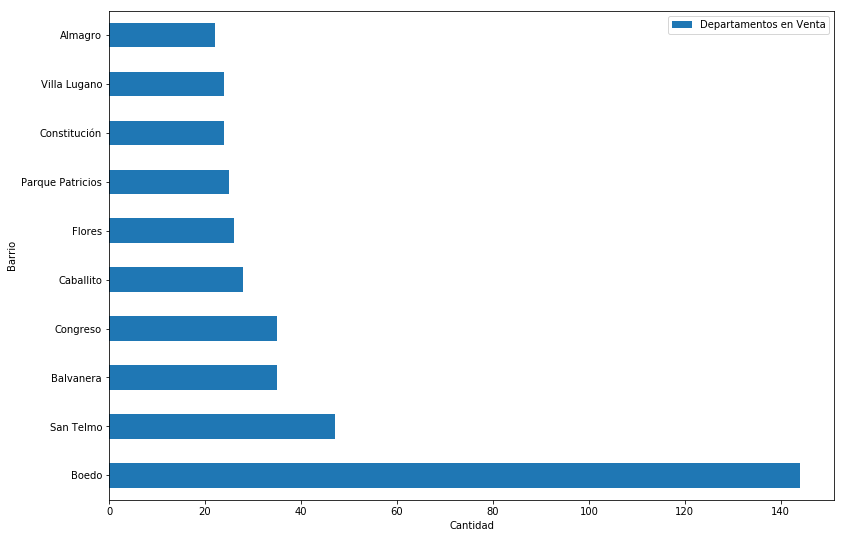

In [25]:
from matplotlib.pyplot import *
fig, ax = subplots()
departamentos_en_zona_en_precio.sort_values(by='apartment', ascending=False)[:10].plot(kind='barh', figsize=(13, 9), ax=ax)
ax.set_ylabel(ylabel="Barrio")
ax.set_xlabel(xlabel="Cantidad")
ax.legend(["Departamentos en Venta"])

### 7.2 ¿Existe y cómo es la relación entre precios de departamentos por barrios de Capital Federal y la cantidad de departamentos en venta en esa zona?

In [26]:
#Seteo de parámetros de consulta:
state_name_filter = 'Capital Federal'
property_type_filter = 'apartment'

In [27]:
# reutilizo el dataframe ya filtrado antes para 'state_name=Capital Federal' y  'property_type=apartment'
propiedades_en_zona_por_tipo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27037 entries, 2 to 121219
Data columns (total 26 columns):
Unnamed: 0                    27037 non-null int64
operation                     27037 non-null object
property_type                 27037 non-null object
place_name                    27037 non-null object
place_with_parent_names       27037 non-null object
country_name                  27037 non-null object
state_name                    27037 non-null object
geonames_id                   25950 non-null float64
lat-lon                       19446 non-null object
lat                           19446 non-null float64
lon                           19446 non-null float64
price                         24154 non-null float64
currency                      24154 non-null object
price_aprox_local_currency    24154 non-null float64
price_aprox_usd               27037 non-null object
surface_total_in_m2           22580 non-null float64
surface_covered_in_m2         25240 non-null float64


In [28]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
import numpy as np

In [29]:
output_notebook()

Loading BokehJS ...

In [30]:
propiedades_en_zona_por_tipo['price_aprox_usd'] = pd.to_numeric(propiedades_en_zona_por_tipo['price_aprox_usd'], errors='coerce')

/Users/Cristian/anaconda3/envs/dsdh-data/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
propiedades_en_zona_por_tipo_grouped = propiedades_en_zona_por_tipo.groupby('place_name').price_aprox_usd.agg(['count', 'mean', 'std'])
print(propiedades_en_zona_por_tipo_grouped.shape)
print(propiedades_en_zona_por_tipo_grouped.info())
display(propiedades_en_zona_por_tipo_grouped.head())

(62, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, Abasto to Villa del Parque
Data columns (total 3 columns):
count    62 non-null int64
mean     62 non-null float64
std      61 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1.9+ KB
None


,count,mean,std
place_name,,,
Abasto,79,126161.137595,60414.278426
Agronomía,29,131240.517241,39038.056532
Almagro,1023,153676.662815,105770.076581
Balvanera,584,133606.016712,87068.353927
Barracas,324,164369.653549,118740.789583


In [62]:
from bokeh.plotting import figure, show , output_file
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, NumeralTickFormatter
from bokeh.layouts import gridplot

output_file("barplot.html", title="Relación Precios y Cantidades en Venta")

data_bokeh = ColumnDataSource(propiedades_en_zona_por_tipo_grouped)

options = {'plot_width': 900,
           'plot_height': 600,
           'tools': 'pan,wheel_zoom,box_zoom,box_select,lasso_select, reset'}

p1 = figure(title="Relación Precios y Cantidades en Venta por Barrio", **options)
p1.circle("count", "mean", color="blue", source = data_bokeh)

p2 = figure(title="Dispersión de Precios Aprox. en relación con las Cantidades en Venta por Barrio", **options)
p2.circle("count", "std", color="green", source = data_bokeh)

labels = LabelSet(x='count', y='mean', text='place_name', text_font_size="8pt", text_color="grey", level='glyph',
              x_offset=5, y_offset=3, source=data_bokeh, render_mode='canvas')
citation = Label(x=70, y=270, x_units='screen', y_units='screen',
                 text='.+ Dataset Properatti 2017 +.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=1.0)

p1.add_layout(labels)
p1.add_layout(citation)
p1.yaxis.formatter = NumeralTickFormatter(format="00")
p1.yaxis.axis_label = "Precio Aprox en Dólares"
p1.xaxis.axis_label = "Departamentos en Venta"

show(p1)